# Binary classification of images using pre-trained VGG Face CNN on Keras

**Goal**  
The goal of this challenge is to develop a binary classification model which tries to detect if an image contains some property or not. 

<br/>
**Dataset**  
The dataset contains raw color images which represent faces. Each image is of size 56 x 56 x 3. The last dimension is the channel and encodes the color : red-green-blue.

There are 116157 images of training and 59429 images of validation.

 <br/>
   
**The performance criterion**

As the data is slightly unbalanced, the performance criterion will be the average accuracy for each class, which is computed as follows:

$$score=\frac{1}{2}(\frac{1}{N_0}\sum^N_{i=1}(1−y_i)(1−ŷ_i)+\frac{1}{N_1}\sum^N_{i=1}y_iŷ_i)$$

where $N$ denotes the total number elements of the dataset, $N_0$ denotes the number of elements whose labels are 0, $N_1$ similarly denotes the number of elements whose labels are 1, $y_i$ denotes the true label of the data sample $i$, and $ŷ_i$ denotes the predicted label for the data sample $i$.


## Dataset : color images of faces

### Load packages

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen

# Keras with Tensorflow backend
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, ZeroPadding2D, Convolution2D, MaxPooling2D, Flatten, Activation
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.callbacks import EarlyStopping, ProgbarLogger, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
import tensorflow as tf
from IPython.display import SVG

# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#google drive working directory
gdwd = '***'

Using TensorFlow backend.


    100% |████████████████████████████████| 993kB 19.5MB/s 


### Load data

Code below allows to load files from google drive to google colab.

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Dataset is splitted in traning set, 10000 images, and in test set with 16157 images.

In [0]:
#num_train_images = 116157
train_size = 100000
test_size = 16157

# download of labels (y_train)
labels = urlopen('***')
y_train = np.array(labels.read(train_size*2).split()).astype(int)
y_test = np.array(labels.read(test_size*2).split()).astype(int)

# download of images (X_train)
images =  urlopen('***')
num_train_images = train_size
height = 56
width = 56
channel = 3
image_dim = height * width * channel

X_train = np.zeros([num_train_images, image_dim])
X_test = np.zeros([test_size, image_dim])

for i, image in enumerate(range(num_train_images)) :
  image_b = images.read(image_dim)  # read image_dim bytes from images (binary format)
  image = np.frombuffer(image_b, dtype=np.uint8) # convert to int in array
  X_train[i,:] = image
  
for i, image in enumerate(range(test_size)) :
  image_b = images.read(image_dim)  # read image_dim bytes from images (binary format)
  image = np.frombuffer(image_b, dtype=np.uint8) # convert to int in array
  X_test[i,:] = image
  
X_train = X_train.reshape(X_train.shape[0], width, height, channel)
X_test = X_test.reshape(X_test.shape[0], width, height, channel)

Computation of ratio between classes

In [0]:
unique, counts = np.unique(y_train, return_counts=True)
n_classes = dict(zip(unique, counts))

print('rate classe0/classe1 : ', n_classes[0]/n_classes[1])

rate classe0/classe1 :  0.6813221917716092


### Images exploration

class :  [1 1 1 0 0 1 1 1 1 0]
class :  [1 1 1 1 0 1 1 1 0 0]
class :  [1 0 1 0 1 0 1 0 0 0]
class :  [0 1 1 1 0 1 1 1 0 1]
class :  [1 1 1 0 1 1 0 0 1 1]
class :  [1 0 0 1 0 0 1 1 0 1]
class :  [0 0 1 0 0 1 1 0 1 0]
class :  [1 0 1 1 1 1 0 1 1 1]
class :  [1 0 0 1 0 1 1 1 1 1]
class :  [1 1 0 1 0 0 1 0 0 0]


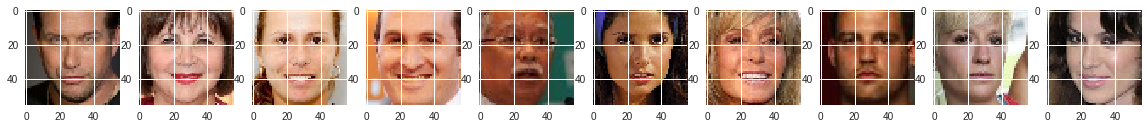

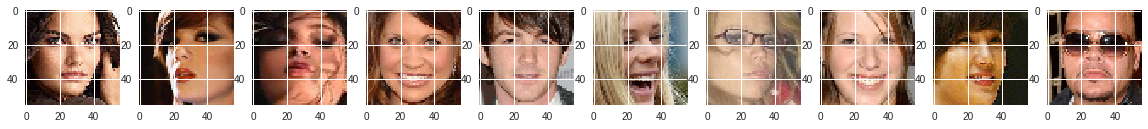

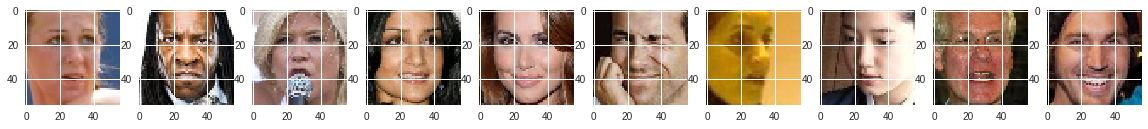

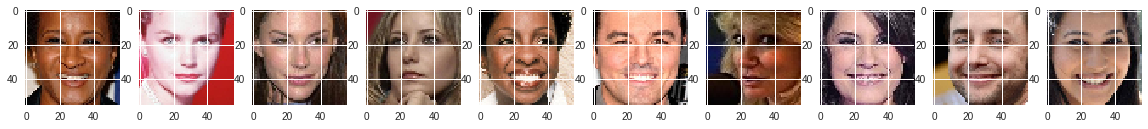

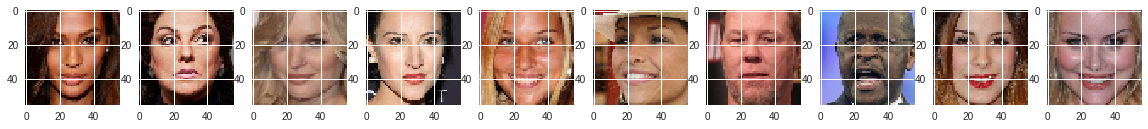

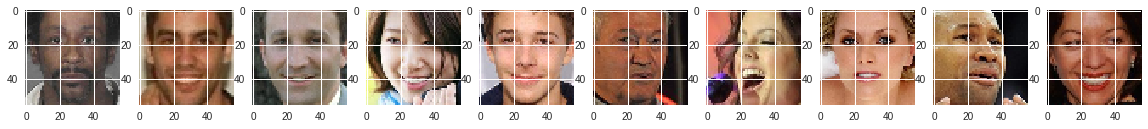

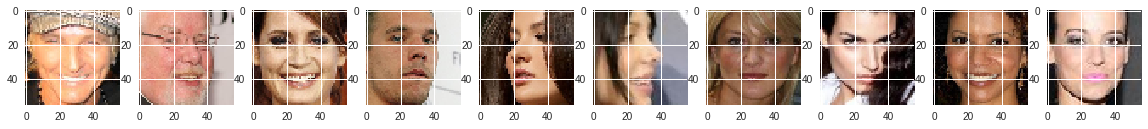

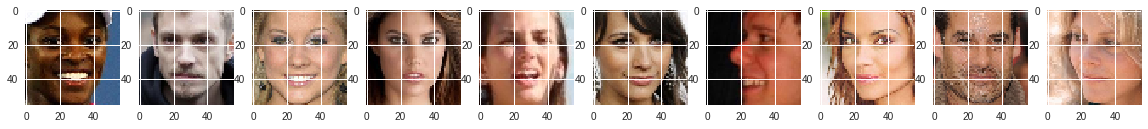

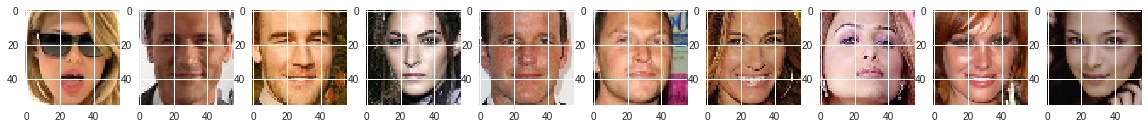

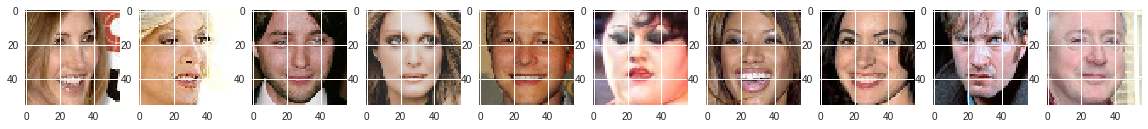

In [0]:
for j in range(10):
  # Plot faces
  ncols = 10
  fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 12))
  for i, ax in enumerate(axes):
      ax.imshow(X_train[1000+j*100+i].astype(np.uint8))
  print('class : ',y_train[1000+j*100:1000+j*100+ncols])


Following observations above, we can perform the analysis below :

**1. Are images of the same shape and dimension?**  
As said in introduction, all images are 56x56x3. We do not need to resize them.

**2. Are images well-aligned?**  
As observed above, all images are croped in order to align faces. Eyes, noise and mouth are aligned.  
If we had noticed that images are not aligned, we could run with SciPy a convolution or correlation in order to find the best alignment. But these methods should be used only for plain translations. For faces alignement, deeper analysis is need. A package is dedicated to this transformation [4].

**3. Is exposure of the images always the same? (Is lightness/contrast the same?)**   
Images below shows slighly different exposure, but contrast seem enough to keep a sufficient level of details.  
If it is not, we may normalize images. We should take care that normalize image may hide many details on faces. For example if we have a very light or dark pixel on background.  
 
**4. Is there noise in the image?**  
No noise is observed on images above.  
Some pre-processing noise reduction are available with OpenCV package [3] like low-pass filters or blur.
<br/>
<br/>

In conclusion, the dataset provides images with robust pre-processing. The variance between observations is probably focus on dissimilarity of faces rather than second order differences as background, face size/position, additional objets or exposure.

If we knew the meaning of each class {0,1}, data augmentation may be relevant in case of overfitting. Indeed, as images only contain faces, during data augmentation we cannot higlight second order element. But geomtric transformation should be used carefully since we're not sure we will not affect determinant data.


## Neural network

### CNN Model : VGG16 pretrainded on faces

VGG16 model has been proposed by Visual Geometry Group of Oxford in 2015 [1].  

The main advantage of this model is VGG trained the network on a very large scale dataset of face images, 2.6M images, over 2.6K people [2]. As precised in paper [1], images used for this training are of shape 224 × 224 x 3 pixels. Thus, the network has been modeled for larger image than proposed in the challenge. 2 strategies may be used when we face this situation :
- Resize images to correspond to initial shape. Three options : zero padding layer, add a neutral strip around images or rescale images with an extrapolation strategy by using opencv library.
- Adapt network to allow smaller images.   

I choosed second option as resize images will lead to an out-of-memory. Indeed, 12 Go is available on Google Colab and load full dataset takes up already 9 Go.   
Therefore, the 2 last max pooling layers are removed to avoid dimension issue.

<br/>
NB : Having slightly larger source images is useful for doing basic data augmentation. For example, you can train your CNN by taking several random 224x224 crops from the same 256x256 image.



### Initialization of VGG16 model

First, I build same model as VGG in order to be able to load pre-trained model. Second, I removed the "top", which are classification layers. I replaced it by a fully connected network. Classifier will be trained from scratch.  
Model has been inspired by following references [5], [6] and [7].

In [0]:
K.clear_session()

height = 56
width = 56
channel = 3


model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(height, width, channel))) # ZeroPadding = 1 to keep initial size after conv 3x3
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2))) #28 #128
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2))) #14 #64
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2))) #7 #32
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
#model.add(MaxPooling2D(1,1)) # Removed to allow images of 56x56x4

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
#model.add(MaxPooling2D((1,1))) # Removed to allow images of 56x56x4

# Classifcation layers
# These layers are not considered in final model as we involve FC layers, but we
# need to instantiate them in order to be coherent with pretrained model
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())

# Load VGG face pretrained model
file_id = '1hM0DC9Wg4T7upjkQgCTe0wzId5SW2pCa'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('vgg_face_weights.h5')
model.load_weights('vgg_face_weights.h5')

# home made classification layers
x = Flatten()(model.layers[-8].output)
x = Dense(256,  kernel_initializer='random_uniform', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256,  kernel_initializer='random_uniform', activation='relu')(x)
x = Dropout(0.5)(x)
sigmoid = Dense(1, activation='sigmoid')(x)
model = Model(inputs=model.input, outputs=sigmoid)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 58, 58, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 64)        1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
__________

## Training of CNN
Since we have a reasonable volume images (100000), the whole CNN may be trained. But, in order to keep the advantage of pretrained VGGFace model, I performed the training in several steps which are introduced below.

### Methodology : Tuning classifier layers then fine-tuning convolutional layers
Training follows a methodology in 3 steps. There are introduced by F. Chollet in this post [5] :  
- i. Train the classifier layers with a "regular" learning rate optimizer while convolutional filters are frozen.  
- ii. Train the classifier layers with a very small learning rate optimizer while convolutional filters are frozen.  
- iii. Last step, train the whole model with a very small learning rate optimizer.    
In two last step we should use a fixed learning rate optimizer like SGD rather than an adaptative learning rate optimizer such as RMSProp or Adam.


In [0]:
# Freeze conv layers
for layer in model.layers[:28] :
  layer.trainable = False

for layer in model.layers[28:] :
  layer.trainable = True
    
model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))

INFO:tensorflow:Querying Tensorflow master (grpc://10.88.24.202:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3813312691483276814)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5007468820579669644)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5495024102761647043)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12241004500828356684)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12565398487978798459)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

### Image preprocessing for VGGFace network

VGG only performs one preprocessing before to feed their neural network with dataset [1]:  
*"The input to all networks is a face image of size 224 × 224 with the average face image (computed from the training set) subtracted – this is critical for the stability of the optimisa- tion algorithm."*  
This is done by preprocess_input function of Keras vgg16 module. Remark : There is no guarantee that others preprocess_input function peform same transformation.

In [0]:
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
print('\nTraining set\n------------')
print('Initial RGB values for first pixel of first image :', X_train[0][0][0])
X_train = preprocess_input(X_train)
print('Prerocessed RGB values for first pixel of first image :', X_train[0][0][0],\
      '\nThe average face image (computed from the training set) has been subtracted')

from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
print('\nTest set\n--------')
print('Initial RGB values for first pixel of first image :', X_test[0][0][0])
X_test = preprocess_input(X_test)
print('Prerocessed RGB values for first pixel of first image :', X_test[0][0][0],\
      '\nThe average face image (computed from the test set) has been subtracted')


Training set
------------
Initial RGB values for first pixel of first image : [156. 148. 145.]
Prerocessed RGB values for first pixel of first image : [41.061 31.221 32.32 ] 
The average face image (computed from the training set) has been subtracted

Test set
--------
Initial RGB values for first pixel of first image : [129. 108.  91.]
Prerocessed RGB values for first pixel of first image : [-12.939  -8.779   5.32 ] 
The average face image (computed from the test set) has been subtracted


### Custom metric for unbalanced dataset  
As precised in Introduction, custom metric is used as dataset is unbalanced.  
Keras deals with their own tensor object, therefore custom metric needs to use Tensorflow operation. (see: https://www.tensorflow.org/api_docs/python/tf/keras/).

In [0]:
def compute_pred_score_keras(y_true, y_pred):
    y0 = 0
    y1 = 0
    if y_true == 0 :
      y0 = 1
    else :
      y1 = 1
    
    acc1 = K.mean(1-y_pred[y0])
    acc2 = K.mean(y_pred[y1])
    
    return (acc1+acc2)/2
  
def compute_pred_score(y_true, y_pred):
    if(y_true.shape[0] != y_pred.shape[0]):
        raise Exception("y_pred and y_true must have the same size")
    tmp = np.unique(y_pred)
    if(tmp.shape[0] > 2):
        raise("y_pred should only contain 0 and 1")
        
    if(tmp.shape[0] == 1):
        if(tmp[0] != 0 and tmp[0] != 1):
            raise Exception("y_pred should only contain 0 and 1")
    else:
        if(tmp[0] != 0 and tmp[1] != 1):
            raise Exception("y_pred should only contain 0 and 1")
    
    y0 = (y_true == 0)
    y1 = (y_true == 1)
    
    acc1 = np.mean(1-y_pred[y0])
    acc2 = np.mean(y_pred[y1])
    
    return (acc1+acc2)/2

### Function to plot loss and accurate curves

In [0]:
def plot_history(history):
  
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

### Advanced strategy to avoid overfitting 

A callback is a set of functions to be applied at given stages of the training procedure
(see : https://keras.io/callbacks/).  

I decided to use two methods of callback set functions :
<br>
1. **Early Stopping**:  
**monitor** : quantity to be monitored.  
**min_delta** : minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.  
**patience** : number of epochs with no improvement after which training will be stopped. Improvement here means increase, as Keras monitors accurate quantity. I set it with a large value as I noticed with default parameters of Adamax optimizer, val_acc may oscillate many times before increase.   
**mode** : <kbd>max</kbd> mode, it will stop when the monitored quantity has stopped to increase. Set it as min if quantity to be monitored is a loss.   
<br>
2. **Checkpoint**:   
**save_best_only** : The latest best model according to the quantity monitored will not be overwritten.  


In [0]:
# checkpoint
filepath= 'VGGFace16_FC2Dense_Adamax_best.h5'

checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_acc',
                             mode='max',
                             verbose=0, 
                             save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               mode='max',
                               verbose=1,
                               patience=10)

callbacks_list = [checkpoint, early_stopping]

### Compile and training model  

Defaut adamax learning rate has been divised by two in order to avoid high oscillation in test accuracy. Indeed, this phenomenon has been observed with default value.

In [0]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adamax(lr=0.0005), 
              metrics=['accuracy', compute_pred_score_keras])

INFO:tensorflow:Cloning Adamax {'lr': 0.0005000000237487257, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07}


In [0]:
history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=64, 
                    validation_data=(X_test, y_test), class_weight={0: 1, 1: 0.6861}, 
                    callbacks=callbacks_list, 
                    verbose=1)
print('------- END -------')

Train on 100000 samples, validate on 16157 samples
Epoch 1/100
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 56, 56, 3), dtype=tf.float32, name='zero_padding2d_input_10'), TensorSpec(shape=(8, 1), dtype=tf.float32, name='dense_2_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adamax {'lr': 0.0005000000237487257, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07}
INFO:tensorflow:Remapping placeholder for zero_padding2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adamax object at 0x7f5b4a3df9e8> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.914342403411865 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0005000000237487257 {0.0005}
INFO:tensorflow:CPU -> TPU beta_1: 0.8999999761581421 {0.9}
INFO

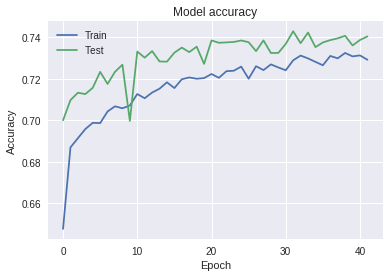

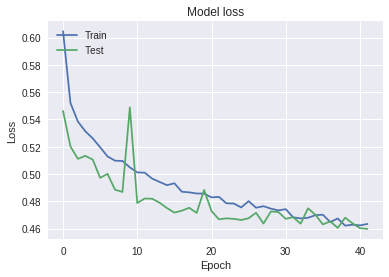

In [0]:
plot_history(history)

Plots above show that model do not overfit and seem converge. The first training is efficient.

### Fine tuning of classification layers
As described above, I start fine tuning on classification layers only. To achieve this, I use stochastic gradient descent with a very slow learning rate rather than an adaptative learning rate optimizer such as RMSProp or Adam.

In [0]:
# checkpoint
early_stopping2 = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               mode='max',
                               verbose=1,
                               patience=3)

callbacks_list2 = [early_stopping2]

In [0]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=0.9e-4, momentum=0.9), metrics=['accuracy', compute_pred_score_keras])

INFO:tensorflow:Cloning SGD {'lr': 9.000000136438757e-05, 'momentum': 0.8999999761581421, 'decay': 0.0, 'nesterov': False}


In [0]:
history2 = model.fit(X_train, y_train, 
                     epochs=20, batch_size=64, 
                     validation_data=(X_test, y_test), class_weight={0: 1, 1: 0.6861}, 
                     callbacks = callbacks_list2,
                     verbose=1)
print('------- END -------')

Train on 100000 samples, validate on 16157 samples
Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(8, 56, 56, 3), dtype=tf.float32, name='zero_padding2d_input_10'), TensorSpec(shape=(8, 1), dtype=tf.float32, name='dense_2_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning SGD {'lr': 9.000000136438757e-05, 'momentum': 0.8999999761581421, 'decay': 0.0, 'nesterov': False}
INFO:tensorflow:Remapping placeholder for zero_padding2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.SGD object at 0x7f5b3b307b38> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.3918468952178955 secs
 99904/100000 [============================>.] - ETA: 0s - loss: 0.4438 - acc: 0.7446 - compute_pred_score_keras: 0.7446INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [Tenso

Obviously, this step does not improve the CNN. First training was efficient.
Let's try to re-train the whole model with fine tuning.

### Fine tuning of the whole model

Last step, I fine-tune the model in setting each layer as trainable. I keep a very small learning rate optimizer.

In [0]:
for layer in model.layers :
  layer.trainable = True

In [0]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=0.5e-4, momentum=0.5), metrics=['accuracy', compute_pred_score_keras])

INFO:tensorflow:Cloning SGD {'lr': 4.999999873689376e-05, 'momentum': 0.5, 'decay': 0.0, 'nesterov': False}


In [0]:
history3 = model.fit(X_train, y_train, 
                     epochs=50, batch_size=64, 
                     validation_data=(X_test, y_test), class_weight={0: 1, 1: 0.6861}, 
                     callbacks = callbacks_list2,
                     verbose=1)

Train on 100000 samples, validate on 16157 samples
Epoch 1/50
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id_40'), TensorSpec(shape=(8, 56, 56, 3), dtype=tf.float32, name='zero_padding2d_input_10'), TensorSpec(shape=(8, 1), dtype=tf.float32, name='dense_2_target_50')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning SGD {'lr': 4.999999873689376e-05, 'momentum': 0.5, 'decay': 0.0, 'nesterov': False}
INFO:tensorflow:Remapping placeholder for zero_padding2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.SGD object at 0x7f5b397d95c0> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 10.965222358703613 secs
 99840/100000 [============================>.] - ETA: 0s - loss: 0.4692 - acc: 0.7305 - compute_pred_score_keras: 0.7305INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(4,

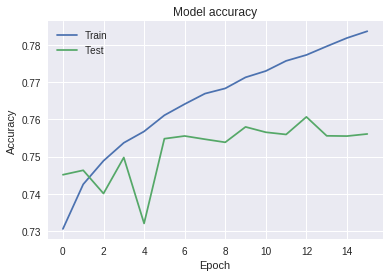

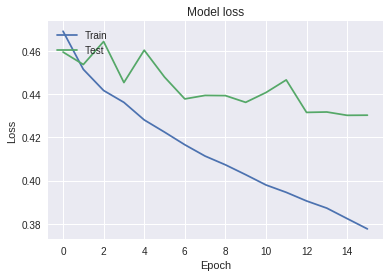

In [0]:
plot_history(history3)

Plots above show that model begins to overvit. Thanks to early stopping, this phenomenon has been avoided.

## Prediction and accuracy

### Score on test set

In [0]:
model = model.sync_to_cpu()

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adamax(lr=0.0005), 
              metrics=['accuracy', compute_pred_score_keras])

y_proba = model.predict(X_test)
y_pred = np.where(y_proba>0.5,1,0)

print('Score :', compute_pred_score(y_test, y_pred))

Score : 0.7822167403310235


## Conclusion

To improve score I could have resorted to stacking : train several CNN and add a meta learner which makes the final prediction from probabilities returned by each CNN.

# References
[1] http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf  
[2] http://www.robots.ox.ac.uk/~vgg/software/vgg_face/  
[3] https://opencv-python-tutroals.readthedocs.io/en/latest/index.html  
[4] https://github.com/1adrianb/face-alignment  
[5] https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html  
[6] https://www.kaggle.com/harveywang/use-keras-pre-trained-vgg16-acc-98  
[7] https://hackernoon.com/learning-keras-by-implementing-vgg16-from-scratch-d036733f2d5  